IndexError: list index out of range

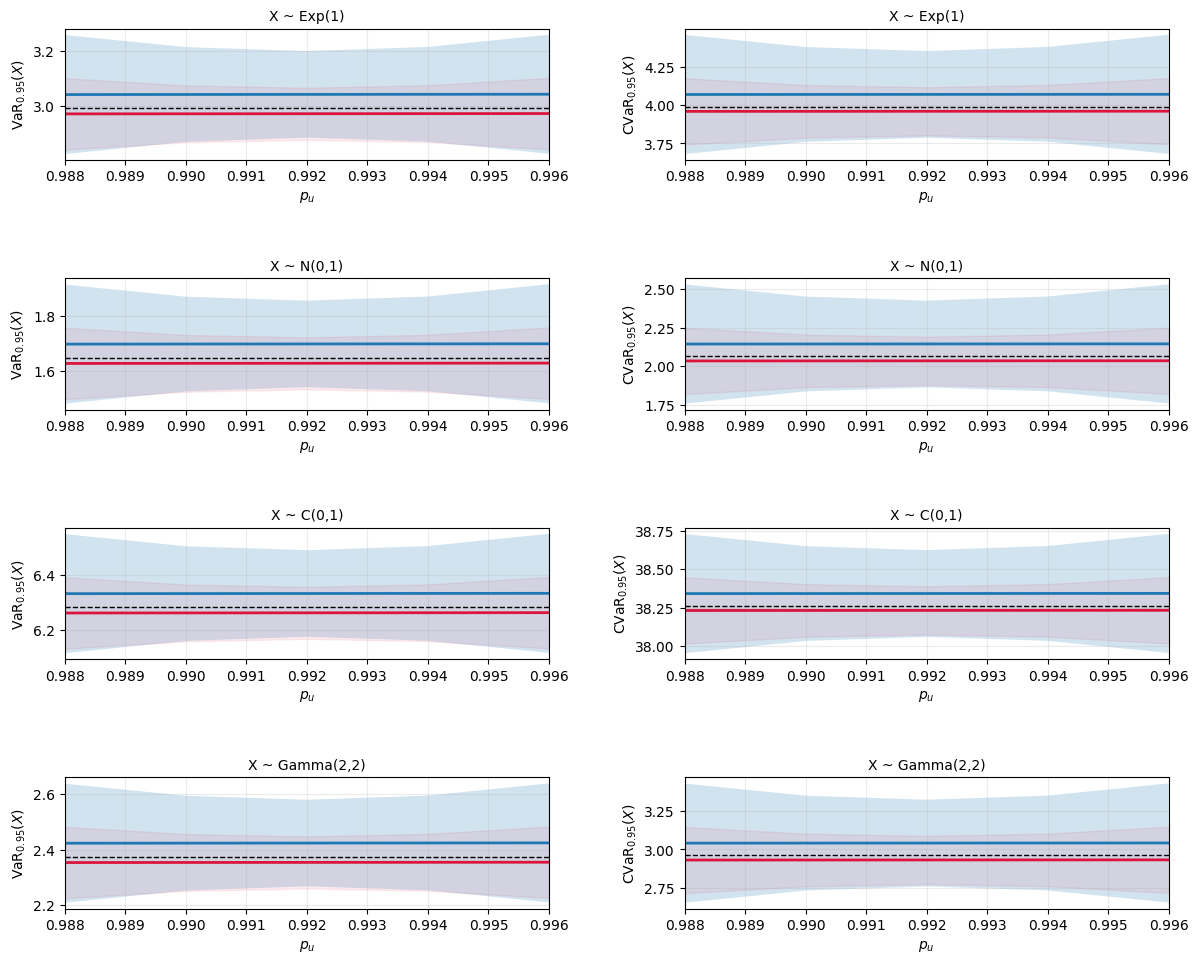

In [2]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

# ------------------------------------------------------------
# Helper: numerical "true" VaR/CVaR from a very large sample
# ------------------------------------------------------------
def var_cvar_true(sample, alpha=0.95):
    q = np.quantile(sample, alpha)
    tail = sample[sample >= q]
    cvar = tail.mean() if tail.size else np.nan
    return float(q), float(cvar)

# Big samples to approximate "true" values
N_true = 2_000_000
dist_defs = [
    ("X ~ Exp(1)",          rng.exponential(1.0, N_true)),
    ("X ~ N(0,1)",          rng.normal(0.0, 1.0, N_true)),
    ("X ~ C(0,1)",          rng.standard_cauchy(N_true)),
    ("X ~ Gamma(2,2)",      rng.gamma(shape=2.0, scale=0.5, size=N_true)),  # rate=2 => scale=0.5
]

true_vals = []
for name, big_sample in dist_defs:
    # clip extreme Cauchy values to avoid overflow in plotting while keeping heavy tail feel
    if "C(0,1)" in name:
        big_sample = np.clip(big_sample, -1e3, 1e3)
    v, c = var_cvar_true(big_sample, 0.95)
    true_vals.append((v, c))

# ------------------------------------------------------------
# Fake-estimator generator (to mimic EVB/IPB curves + bands)
# ------------------------------------------------------------
def fake_estimates(true_value, pu_grid, method_bias=0.0, base_sd=0.12):
    """
    Create smooth means around the truth (slightly biased),
    with narrower bands near the center pu and wider at ends.
    """
    center = pu_grid.mean()
    spread = (pu_grid - center)
    sd = base_sd * (0.8 + 1.2 * (spread / np.ptp(spread))**2)  # fixed
    mean = true_value + method_bias + 0.15 * spread
    low  = mean - 1.96 * sd
    high = mean + 1.96 * sd
    return mean, low, high


# x-axis grid (pick values similar to the captioned figure)
pu = np.array([0.988, 0.990, 0.992, 0.994, 0.996])

# ------------------------------------------------------------
# Build all panels' curves
# ------------------------------------------------------------
panels = []
for i, (name, _) in enumerate(dist_defs):
    tv_var, tv_cvar = true_vals[i]

    # Make EVB (blue) and IPB (red) estimates
    evb_var_mean, evb_var_lo, evb_var_hi   = fake_estimates(tv_var,  pu, method_bias=+0.05, base_sd=0.10)
    ipb_var_mean, ipb_var_lo, ipb_var_hi   = fake_estimates(tv_var,  pu, method_bias=-0.02, base_sd=0.06)

    evb_cvar_mean, evb_cvar_lo, evb_cvar_hi = fake_estimates(tv_cvar, pu, method_bias=+0.08, base_sd=0.18)
    ipb_cvar_mean, ipb_cvar_lo, ipb_cvar_hi = fake_estimates(tv_cvar, pu, method_bias=-0.03, base_sd=0.10)

    panels.append({
        "name": name,
        "true_var": tv_var, "true_cvar": tv_cvar,
        "evb_var": (evb_var_mean, evb_var_lo, evb_var_hi),
        "ipb_var": (ipb_var_mean, ipb_var_lo, ipb_var_hi),
        "evb_cvar": (evb_cvar_mean, evb_cvar_lo, evb_cvar_hi),
        "ipb_cvar": (ipb_cvar_mean, ipb_cvar_lo, ipb_cvar_hi),
    })

# ------------------------------------------------------------
# Plot: 4 rows × 2 cols. Left: VaR, Right: CVaR
# ------------------------------------------------------------
plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=0.9, wspace=0.28, left=0.06, right=0.98, top=0.95, bottom=0.07)

for r, p in enumerate(panels, start=1):
    # left subplot (VaR)
    axL = plt.subplot(4, 2, 2*r - 1)
    evb_m, evb_lo, evb_hi = p["evb_var"]
    ipb_m, ipb_lo, ipb_hi = p["ipb_var"]

    axL.fill_between(pu, evb_lo, evb_hi, alpha=0.2, label="EVB 95% band")   # blue-ish default
    axL.plot(pu, evb_m, lw=2, label="EVB")
    axL.plot(pu, ipb_m, lw=2, color='crimson', label="IPB")
    # optional IPB band (faint)
    axL.fill_between(pu, ipb_lo, ipb_hi, alpha=0.08, color='crimson')

    axL.axhline(p["true_var"], ls="--", color="k", lw=1)
    axL.set_xlim(pu.min(), pu.max())
    axL.set_xlabel(r"$p_u$")
    axL.set_ylabel(r"$\mathrm{VaR}_{0.95}(X)$")
    axL.set_title(p["name"], fontsize=10)
    axL.grid(alpha=0.25)

    # right subplot (CVaR)
    axR = plt.subplot(4, 2, 2*r)
    evb_m, evb_lo, evb_hi = p["evb_cvar"]
    ipb_m, ipb_lo, ipb_hi = p["ipb_cvar"]

    axR.fill_between(pu, evb_lo, evb_hi, alpha=0.2)
    axR.plot(pu, evb_m, lw=2)
    axR.plot(pu, ipb_m, lw=2, color='crimson')
    axR.fill_between(pu, ipb_lo, ipb_hi, alpha=0.08, color='crimson')

    axR.axhline(p["true_cvar"], ls="--", color="k", lw=1)
    axR.set_xlim(pu.min(), pu.max())
    axR.set_xlabel(r"$p_u$")
    axR.set_ylabel(r"$\mathrm{CVaR}_{0.95}(X)$")
    axR.set_title(p["name"], fontsize=10)
    axR.grid(alpha=0.25)

# One legend for the whole figure
handles, labels = axR.get_legend_handles_labels()
plt.legend(handles[:2] + [handles[2]], ["EVB 95% band", "EVB", "IPB"], loc="upper center",
           bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False)

plt.suptitle(
    r"Estimates of $\mathrm{VaR}_{0.95}(X)$ (left) and $\mathrm{CVaR}_{0.95}(X)$ (right) vs $p_u$"
    "\nEVB (blue) with 95% bands, IPB (red). Black dashed = true value.",
    y=0.995, fontsize=12
)
plt.show()


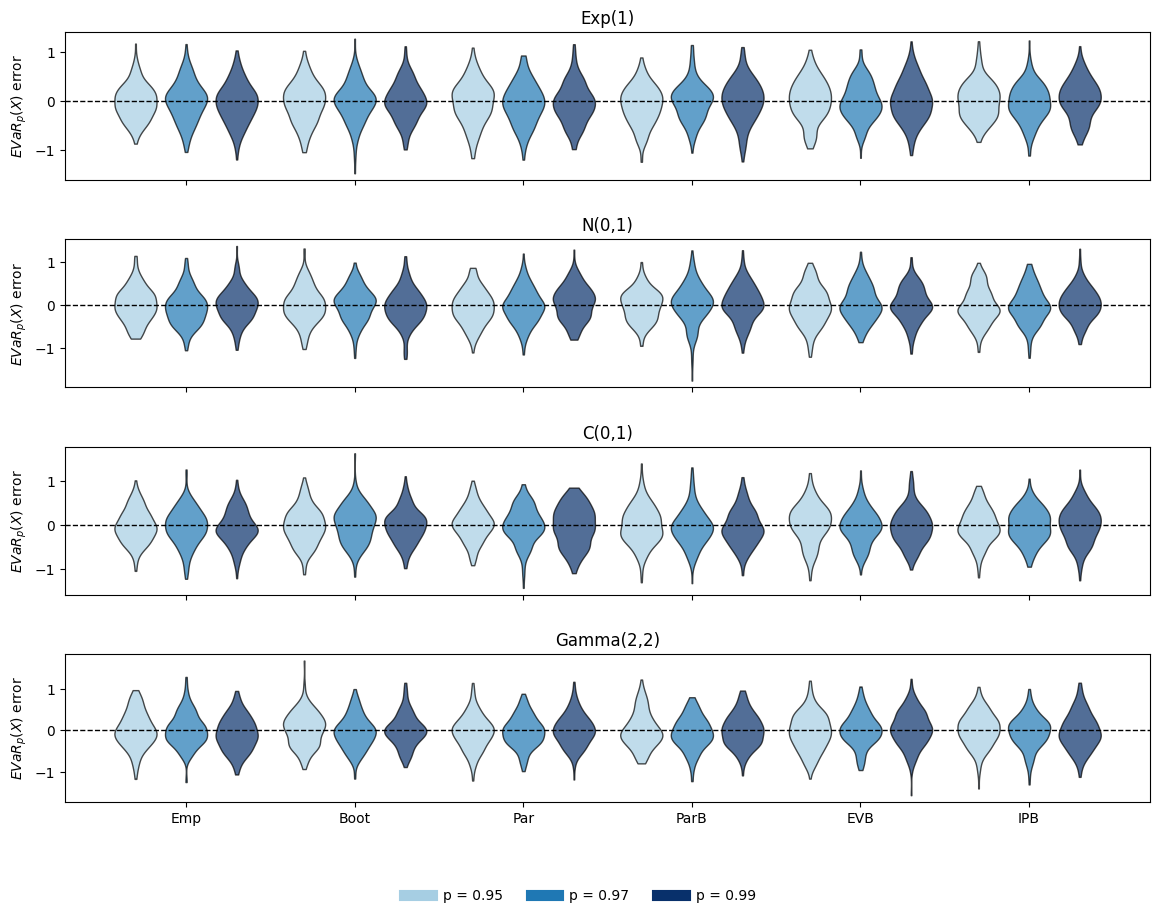

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rng = np.random.default_rng(42)

# ------------------------------
# Setup
# ------------------------------
methods = ["Emp", "Boot", "Par", "ParB", "EVB", "IPB"]
p_levels = [0.95, 0.97, 0.99]
dists = ["Exp(1)", "N(0,1)", "C(0,1)", "Gamma(2,2)"]

# Fake error distributions for demo
# Dictionary structure: errors[dist][method][p] = sample array
errors = {
    d: {
        m: {p: rng.normal(loc=0, scale=1/(p*10) + 0.3, size=200)
            for p in p_levels}
        for m in methods
    }
    for d in dists
}

# ------------------------------
# Plotting
# ------------------------------
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
plt.subplots_adjust(hspace=0.4)

palette = {0.95: "#a6cee3", 0.97: "#1f78b4", 0.99: "#08306b"}

for i, dist in enumerate(dists):
    ax = axes[i]

    # Collect data for this row
    positions = []
    data = []
    colors = []

    offset = np.linspace(-0.3, 0.3, len(p_levels))  # spread violins for each p
    for j, m in enumerate(methods):
        for k, p in enumerate(p_levels):
            positions.append(j + offset[k])
            data.append(errors[dist][m][p])
            colors.append(palette[p])

    # Draw violins
    parts = ax.violinplot(data, positions=positions, widths=0.25,
                          showmeans=False, showmedians=False, showextrema=False)

    # Color each violin
    for pc, c in zip(parts['bodies'], colors):
        pc.set_facecolor(c)
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)

    # Formatting
    ax.axhline(0, ls="--", color="k", lw=1)
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods)
    ax.set_ylabel(r"$EVaR_p(X)$ error")
    ax.set_title(f"{dist}")

# Legend for p-levels
handles = [plt.Line2D([0], [0], color=palette[p], lw=8) for p in p_levels]
labels = [f"p = {p}" for p in p_levels]
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)

plt.show()


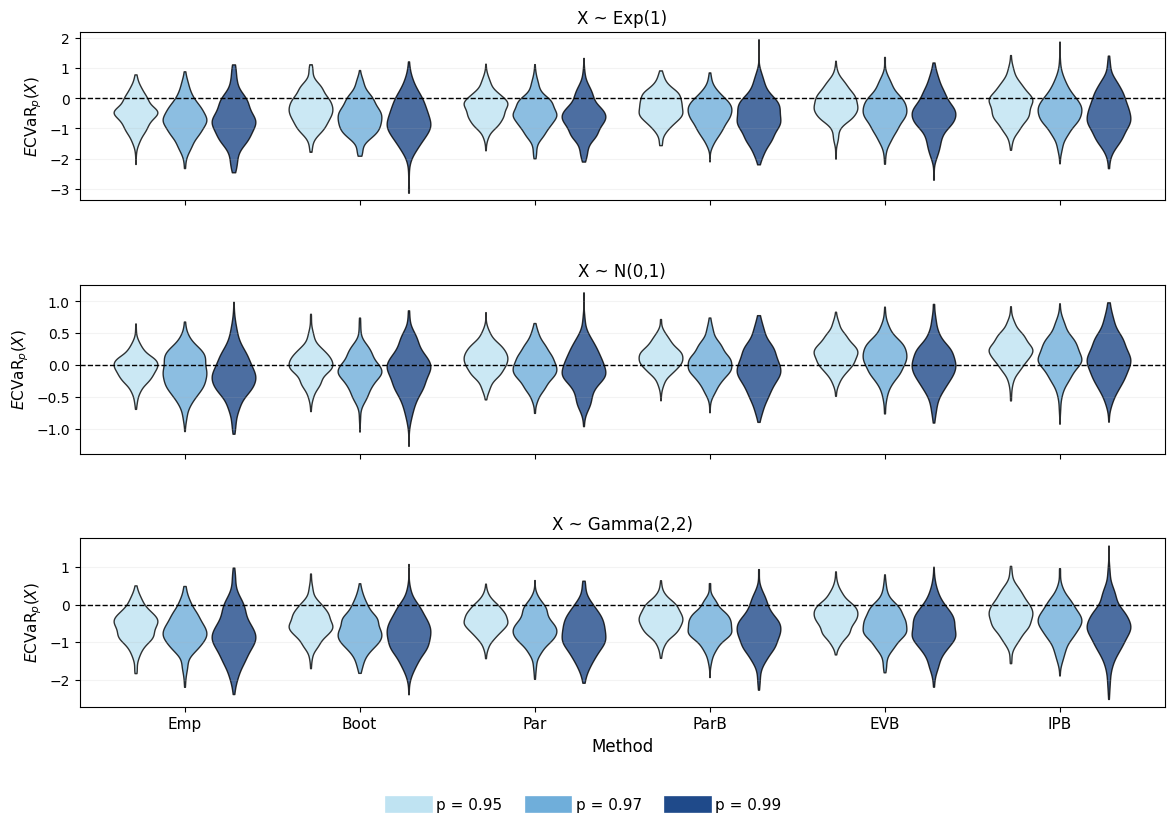

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

rng = np.random.default_rng(7)

# ------------------------------------------------------------
# Config
# ------------------------------------------------------------
rows = [
    ("X ~ Exp(1)",    dict(loc=[-0.3, -0.5, -0.6], scale=[0.45, 0.50, 0.60])),
    ("X ~ N(0,1)",    dict(loc=[ 0.10, 0.00, -0.05], scale=[0.20, 0.25, 0.30])),
    ("X ~ Gamma(2,2)",dict(loc=[-0.4, -0.6, -0.7],  scale=[0.35, 0.40, 0.50])),
]
methods = ["Emp", "Boot", "Par", "ParB", "EVB", "IPB"]
p_levels = [0.95, 0.97, 0.99]
colors = {0.95:"#bfe3f2", 0.97:"#6faeda", 0.99:"#1f4a8a"}  # three blues

# ------------------------------------------------------------
# Synthetic demo data (replace with your real error arrays)
# Desired structure: errors[dist_idx][method_idx][p_idx] -> 1D array of errors
# ------------------------------------------------------------
def demo_errors(loc, scale, n=400):
    """Generate different spreads per method and p for a row."""
    errs = []
    for m in range(len(methods)):
        per_method = []
        for j, p in enumerate(p_levels):
            # small method-dependent tweak so groups look different
            mu = loc[j] + 0.05*(m-2.5)
            sd = scale[j] * (1.0 + 0.08*(abs(m-2.5)))
            per_method.append(rng.normal(mu, sd, n))
        errs.append(per_method)
    return errs

errors = [demo_errors(r[1]["loc"], r[1]["scale"]) for r in rows]

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
plt.subplots_adjust(hspace=0.5, bottom=0.13)

for ridx, (title, _) in enumerate(rows):
    ax = axes[ridx]

    # prepare grouped positions: for each method, 3 offsets for p-levels
    centers = np.arange(len(methods))
    offsets = np.linspace(-0.28, 0.28, len(p_levels))
    pos, data, facecols = [], [], []
    for m in range(len(methods)):
        for j, p in enumerate(p_levels):
            pos.append(centers[m] + offsets[j])
            data.append(errors[ridx][m][j])
            facecols.append(colors[p])

    parts = ax.violinplot(
        data, positions=pos, widths=0.25,
        showmeans=False, showmedians=False, showextrema=False
    )
    for body, c in zip(parts['bodies'], facecols):
        body.set_facecolor(c)
        body.set_edgecolor('black')
        body.set_alpha(0.8)

    # zero-error reference line
    ax.axhline(0.0, ls='--', color='black', lw=1)

    # cosmetics
    ax.set_xlim(-0.6, len(methods)-0.4)
    ax.set_xticks(centers)
    ax.set_xticklabels(methods, fontsize=11)
    ax.set_ylabel(r"$E\mathrm{CVaR}_p(X)$", fontsize=11)
    ax.set_title(title, fontsize=12)
    ax.grid(axis='y', alpha=0.15)

# x-label only on bottom row
axes[-1].set_xlabel("Method", fontsize=12)

# legend for p-levels
legend_handles = [Line2D([0],[0], lw=12, color=colors[p]) for p in p_levels]
fig.legend(legend_handles, [f"p = {p}" for p in p_levels],
           loc="lower center", ncol=3, frameon=False, fontsize=11)

plt.show()
